This is a work-in-progress as a way for me to better understand [modern warp drive theory](https://arxiv.org/abs/2404.03095) and because [Warp Factory](https://github.com/NerdsWithAttitudes/WarpFactory) is in MATLAB. Please make a PR/issue if you have any suggestions.

# Learning Warp Drive Metric Neural Fields
Instead of doing a bunch of backbreaking math by hand let's numerically search for metric tensors which satisfy the conditions of a warp drive.
Using an autodiff framework, in this case JAX, we parameterize a metric tensor with a neural field, `metric_f(x: Point4d) -> MetricTensor`,
We fit metric_f by sampling batches of points and minimizing `warp_loss(x)` The terms of warp loss are chosen in part based on features thought to be important as described by [Analyzing Warp Drive Spacetimes with Warp Factory](https://arxiv.org/abs/2404.03095):

<blockquote>

The field of warp mechanics does not have a unified definition of what is required by
a warp solution. However, there are several aspects that emerge as important features
of any solution. A warp drive aims to provide a controlled and comfortable journey
through space. This goal motivates the three core features of a warp drive: geodesic
transport, a flat passenger region, and a spatially compact and comoving warp bubble.

(i) Geodesic transport. Warp drives should transport passengers from point A to point
B along a geodesic trajectory. This means the passengers inside the warp drive
do not experience local acceleration while being transported.
For a non-trivial solution, the passengers should not ‘already be going to’ point B. One possible scenario is that passengers start at rest (relative to points A and B) at point A, are transported to point B, and are then, again, at rest relative to both points.
Additionally, this transport should occur for a limited region in spacetime.

(ii) Empty passenger region. There should exist a defined passenger volume that is
both vacuum (T_µν = 0) and free from large tidal forces.

(iii) A spatially bounded, comoving bubble. The stress-energy required for the geodesic
transport should not extend to infinity
. The stress-energy of the bubble also needs
to move along with the transported observers. The requirement of it comoving with
passengers distinguishes warp drive solutions from Krasnikov tubes 
</blockquote>

First, let's define three zones which will have different constraints: the inner passenger area, the warp shell, and the rest of the universe.
 * Since we're comoving with the warp drive the solution should be at rest with the warp drive, and the universe would appear to be moving past it. We do this by imposing a loss on the metric shift vector such that it's zero in the passenger area and warp shell, and the rest of the universe has the target shift.
 * We keep both the passenger area and the rest of the universe flat and empty by minimizing the energy density and warping of space.
 * A penalty on negative energy density encourages solutions incompatible with contemporary technology.
 * TODO implement methods from Analyzing Warp Drive Spacetimes with Warp Factory, Section 3
 * TODO more physical constraints on stress-energy tensor
 * TODO more openended loss maybe based on simulated geodesic trajectories

In [10]:
# Install stuff if we're in colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install dm-haiku

In [11]:
from functools import partial

import jax
import jax.numpy as jnp
import haiku as hk
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm

# from jax.config import config
# jax.config.update("jax_debug_nans", True)

I found all of the basic building blocks for modeling relativity in JAX here: https://github.com/haimengzhao/relativity-jax

In [12]:
# Start from https://github.com/haimengzhao/relativity-jax

metric = lambda coords, model: model(coords)

pd_metric = jax.jacfwd(metric)

def christoffel(coords, model):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)
    partial_derivs = jnp.einsum('mns -> smn', pd_metric(coords, model))
    sum_partial_derivs = partial_derivs + jnp.einsum('nrm -> mnr', partial_derivs) - jnp.einsum('rmn -> mnr', partial_derivs)
    christ = 0.5 * jnp.einsum('sr, mnr -> smn', inv_met, sum_partial_derivs)
    return christ
pd_christoffel = jax.jacfwd(christoffel)


def riemann_curvature(coords, model):
    christ = christoffel(coords, model)
    pd_christ = jnp.einsum('rmns -> srmn', pd_christoffel(coords, model))
    return jnp.einsum('mrns -> rsmn', pd_christ) - jnp.einsum('nrms -> rsmn', pd_christ) + jnp.einsum('rml, lns -> rsmn', christ, christ) - jnp.einsum('rnl, lms -> rsmn', christ, christ)


def ricci_tensor(coords, model):
    riemann = riemann_curvature(coords, model)
    return jnp.einsum('rsru -> su', riemann)


def ricci_scalar(coords, model):
    return jnp.einsum('mn, mn -> ', jnp.linalg.inv(metric(coords, model)), ricci_tensor(coords, model))


def einstein_tensor(coords, model):
    met = metric(coords, model)
    ricci_ts = ricci_tensor(coords, model)
    return ricci_ts - 0.5 * jnp.einsum('mn, mn -> ', jnp.linalg.inv(met), ricci_ts).reshape(1, 1) * met

# End https://github.com/haimengzhao/relativity-jax


Here are some primitives we'll need later.

In [13]:
def stress_energy_tensor(model, coords):
    G = einstein_tensor(coords, model)
    T = G / (jnp.pi * 8)
    return T

def energy_density(model, coords):
    return stress_energy_tensor(model, coords)[0, 0]

# Velocity field
def velocity_field(coords):
    u = jnp.zeros_like(coords)
    u = u.at[1].set(1.0)  # u^t = 1, u^i = 0 for i = 1, 2, 3
    return u

# Covariant derivative of the velocity field
def covariant_derivative_u(model, coords):
    u = velocity_field(coords)
    christ = christoffel(coords, model)
    return jax.jacfwd(lambda x: u)(coords) - jnp.einsum('ijk,j->ik', christ, u)

# Shear tensor
def shear_tensor(model, coords):
    cov_deriv_u = covariant_derivative_u(model, coords)
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)

    # Symmetric part of the covariant derivative
    symmetric_part = 0.5 * (cov_deriv_u + jnp.einsum('ij->ji', cov_deriv_u))
    # Remove trace part to get the shear tensor
    trace_part = (1.0 / 3.0) * jnp.einsum('ij,ij->', inv_met, symmetric_part) * met
    shear = symmetric_part - trace_part
    return shear

# Shear scalar
def shear_scalar(model, coords):
    shear = shear_tensor(model, coords)
    return jnp.sqrt(0.5 * jnp.einsum('ij,ij', shear, shear))

# Vorticity tensor
def vorticity_tensor(model, coords):
    cov_deriv_u = covariant_derivative_u(model, coords)
    # Antisymmetric part of the covariant derivative
    antisymmetric_part = 0.5 * (cov_deriv_u - jnp.einsum('ij->ji', cov_deriv_u))
    return antisymmetric_part

# Vorticity scalar
def vorticity_scalar(model, coords):
    vorticity = vorticity_tensor(model, coords)
    return jnp.sqrt(0.5 * jnp.einsum('ij,ij', vorticity, vorticity))

# Expansion scalar
def expansion_scalar(model, coords):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)

    pd_met = pd_metric(coords, model)
    trace_extrinsic_curvature = jnp.einsum('mnm -> n', pd_met)

    theta = jnp.einsum('mn, n -> ', inv_met, trace_extrinsic_curvature)
    return theta

def metric_shift_x(model, coords):
    met = metric(coords, model)
    return met[0, 1]

The [Alcubierre metric](https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fpdf%2Fgr-qc%2F0009013). The warp drive metric that started it all. We'll keep it around for comparison to models we discover.

In [14]:
# Alcubierre metric parameters
v_s = 0.5  # Warp bubble velocity
sigma = 3  # Steepness of the bubble's edge
R = 2  # Radius of the bubble

def alcubierre_metric_comoving(coords):
    t, x_prime, y, z = coords
    r_s = jnp.sqrt(x_prime**2 + y**2 + z**2)
    f_rs = (jnp.tanh(sigma * (r_s + R)) - jnp.tanh(sigma * (r_s - R))) / (2 * jnp.tanh(sigma * R))
    f2 = f_rs**2

    g_tt = -1 + v_s**2 * (1 - f2)
    g_tx = v_s * (1 - f2)

    g = jnp.array([
        [g_tt, g_tx, 0, 0],
        [g_tx, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return g

Just need some plotting code and then it's warping time.

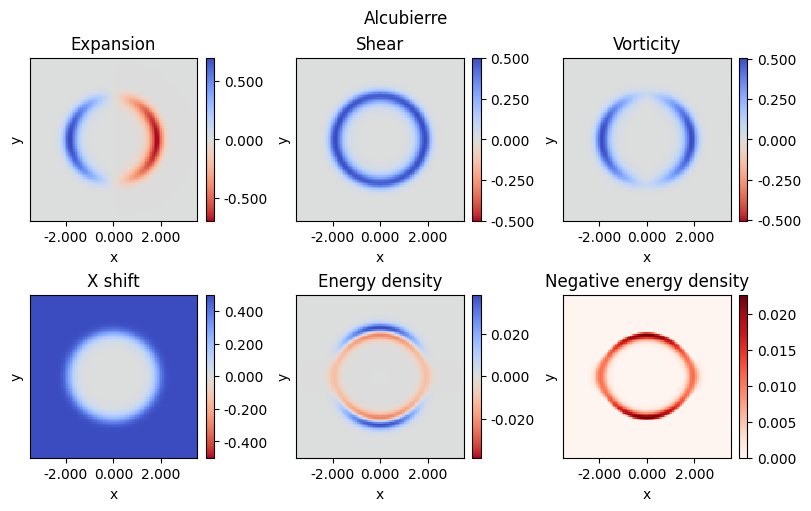

In [16]:
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
from scipy.stats.qmc import Halton

def sample_halton(scalar_field, w, n):
    # Initialize the Halton sequence generator
    sampler = Halton(d=4, scramble=True)

    # Generate n points in the 4D space (t, x, y, z)
    halton_samples = sampler.random(n)

    # Scale the samples to the desired range
    t_samples = 0 * halton_samples[:, 0]  # t = 0 for all points
    x_samples = -w + 2 * w * halton_samples[:, 1]
    y_samples = -w + 2 * w * halton_samples[:, 2]
    z_samples = 0 * halton_samples[:, 3]  # z = 0 for all points

    # Combine into a single array of coordinates
    coords = jnp.stack([t_samples, x_samples, y_samples, z_samples], axis=-1)
    # Compute the expansion scalar over the sampled points using vectorized function
    values = scalar_field(coords)
    X, Y = jnp.meshgrid(x_samples, y_samples, indexing='ij')
    values = jnp.reshape(values_flat, X.shape)
    return X, Y, values

def sample_grid(scalar_field, w, n):
    x_values = jnp.linspace(-w, w, n)
    y_values = jnp.linspace(-w, w, n)

    # Create mesh grids for the coordinates
    X, Y = jnp.meshgrid(y_values, x_values, indexing='ij')

    # Expand dimensions for broadcasting
    Y_flat = Y.flatten()
    X_flat = X.flatten()
    Z_flat = jnp.zeros_like(X_flat)  # z = 0 for all points
    T_flat = jnp.zeros_like(X_flat)  # t = 0 for all points
    # Combine into a single array of coordinates
    coords_flat = jnp.stack([T_flat, X_flat, Y_flat, Z_flat], axis=-1)
    # Compute the expansion scalar over the entire grid using vectorized function
    values_flat = scalar_field(coords_flat)
    values_flat = values_flat.at[jnp.isnan(values_flat)].set(0)
    # Clamp extreme values:
    # if quantile is not None:
    #     qs = jnp.quantile(jnp.abs(values_flat), quantile)
    #     values_flat = values_flat.clip(-qs, qs)

    # Reshape back to match the grid shape
    values = jnp.reshape(values_flat, X.shape)
    return X, Y, values

# Mostly generated by chatgpt, thanks
def plot_scalar_field(
    scalar_field, title='Scalar', color_label=None, w=3, n=100, quantile=None, log_values=True,
    cmap='coolwarm_r', shading='auto',**kwargs):
    # Generate grid points for the plot
    #X, Y, values = sample_halton(scalar_field, w, n ** 2)
    X, Y, values = sample_grid(scalar_field, w, n)
    if log_values:
      values = jnp.sign(values) * jnp.log(1 + jnp.abs(values))
    # Plot the expansion scalar
    plt.pcolormesh(X, Y, values, cmap=cmap, shading=shading, norm=colors.CenteredNorm(), **kwargs)
    plt.colorbar(label=color_label, format='%.3f')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.yticks([])
    plt.title(title)
    return values, X, Y

def plot_scalars(values, X, Y, title='Scalar', color_label=None, cmap='viridis', shading='auto', **kwargs):
    # Plot the expansion scalar
    plt.pcolormesh(X, Y, values, cmap=cmap, shading=shading, **kwargs)
    plt.colorbar(label=color_label, format='%.3f')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.yticks([])
    plt.title(title)

def plot_warp_scalars(f_metric, title, **plot_kwargs):
    plt.figure(figsize=(16, 3))
    for i, (f_scalar, subtitle) in enumerate((
        (expansion_scalar, 'Expansion'),
        (shear_scalar, 'Shear'),
        (vorticity_scalar, 'Vorticity'),
    )):
        plt.subplot(1, 3, i + 1)
        vectorized_scalar = jax.vmap(partial(f_scalar, f_metric), in_axes=(0,))
        subtitle = f'{title} {subtitle}'
        plot_scalar_field(vectorized_scalar, title=subtitle, **plot_kwargs)

def plot_energy(f_metric, title='', w=3, n=100, quantile=None):
    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    vectorized_energy_density = jax.jit(jax.vmap(partial(energy_density, f_metric), in_axes=(0,)))
    values, X, Y = plot_scalar_field(vectorized_energy_density, title=title + ' Energy density', w=w, n=n, quantile=quantile)
    plt.subplot(1, 2, 2)
    plot_scalars(-values.clip(None, 0), X, Y, title=title + ' Negative energy density', cmap='Reds')

def make_plots(f_metric, title='', w=2, n=100, quantile=None):
    plot_kwargs = dict(w=w, n=n, quantile=quantile)
    plt.figure(figsize=(8, 5), layout='constrained')
    plt.suptitle(title)
    # warp scalars
    for i, (f_scalar, subtitle) in enumerate((
        (expansion_scalar, 'Expansion'),
        (shear_scalar, 'Shear'),
        (vorticity_scalar, 'Vorticity'),
        (metric_shift_x, 'X shift')
    )):
        plt.subplot(2, 3, i + 1)
        vectorized_scalar = jax.vmap(partial(f_scalar, f_metric), in_axes=(0,))
        plot_scalar_field(vectorized_scalar, title=subtitle, **plot_kwargs)
    # energy
    plt.subplot(2, 3, 5)
    vectorized_energy_density = jax.jit(jax.vmap(partial(energy_density, f_metric), in_axes=(0,)))
    values, X, Y = plot_scalar_field(vectorized_energy_density, title='Energy density', w=w, n=n, quantile=quantile)
    plt.subplot(2, 3, 6)
    plot_scalars(-values.clip(None, 0), X, Y, title='Negative energy density', cmap='Reds')

    for ax in plt.gcf().get_axes():
      ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
      ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))


make_plots(alcubierre_metric_comoving, title='Alcubierre', w=3.5)
plt.savefig('alcubierre.png')
plt.show()


Here's a plot of the Alcubierre metric. Moving along the x-axis, the expansion scalar plot reveals that space expands on one side and contracts on the other, illustrating the mechanism of warping. However, it also shows that the energy density becomes negative, which is beyond the capabilities of our current technology.

# Model
Let's make a neural field that models the mapping from (t,x,y,z) to entries in a metric tensor--the neural warp drive tensor.
Choosing how to parameterize the metric is important. This parameterization learns a residual to be added to the Minkowski metric tensor and does a couple of things to ensure it has a signature of (-,+,+,+) and is invertible.

In [7]:
num_model_inputs = 4
num_model_outputs = 3
# Define the neural network that outputs the components of the metric tensor
def metric_neural_field_model(coords):
    # gelu and cos seem to work
    hidden_activation = jnp.cos  # jax.nn.gelu  # jnp.tanh # jax.nn.gelu  #
    # tanh or identity have been ok here. remember this value should make sense in the metric tensor
    output_activation = jnp.tanh  #  lambda x: x  #
    net = hk.Sequential([
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(num_model_outputs), #, w_init=jnp.zeros, b_init=jnp.zeros),
        output_activation,
    ])
    return net(coords)

# Prepare the model for use
metric_model_init, metric_model_apply = hk.transform(metric_neural_field_model)

def perturb_minkowski(params, coords):
    """
    Gets the metric params from the nn model and adds them to the Minkowski metric.
    In this case we want to find metrics where there's movement so we explore
    terms in dt^2 and dxdt
    """
    # Add radial component to coords
    # coords = jnp.concatenate([coords, jnp.sum(coords ** 2, keepdims=True)], axis=-1)
    g_values = metric_model_apply(params, None, coords)
    eps = 1e-5
    dm = jnp.array([
        [g_values[0], g_values[1], 0, 0],
        #[g_values[1], g_values[2], 0, 0],
        [g_values[1], 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
    ])
    minkowski = jnp.eye(4)
    minkowski = minkowski.at[0, 0].set(-1.)
    # fall off over distance to prevent hacking the metric in unregulated areas?
    # r = jnp.sqrt(jnp.sum(coords ** 2))
    # dm = dm / (1 + r)
    g = minkowski + dm
    # make sure the overall signature is spacetimey?
    g = g.at[0, 0].set(-jnp.abs(g[0, 0]) - eps)
    g = g.at[1, 1].set(jnp.abs(g[1, 1]) + eps)
    return g

f_metric = perturb_minkowski

# Fit the model

Now let's come up with loss terms which satisfy our core warp engine constraints. Roughly, we want a central "passenger region" that is empty and flat, a region where all of the warp drive effects occur, and then empty and flat once again outside of our system to infinity.

Elapsed: 00:19 | 1 at 19.16s/it, loss=0.27826253

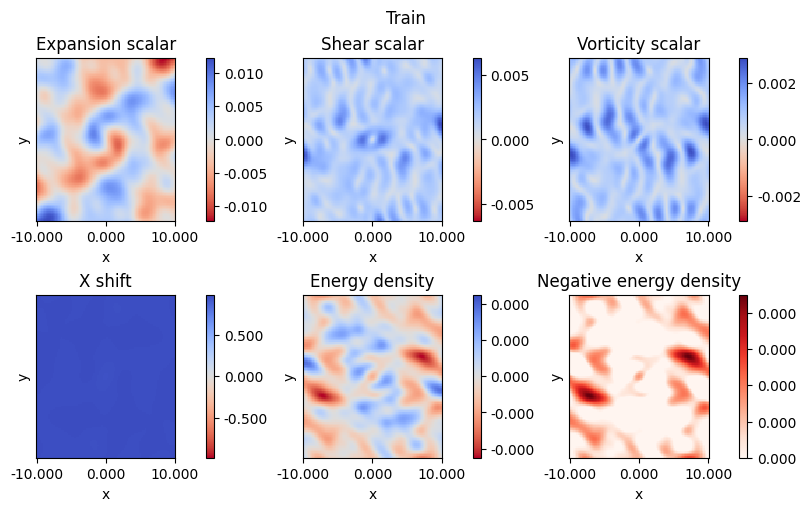

Elapsed: 00:52 | 26 at  1.14s/it, loss=0.030292917

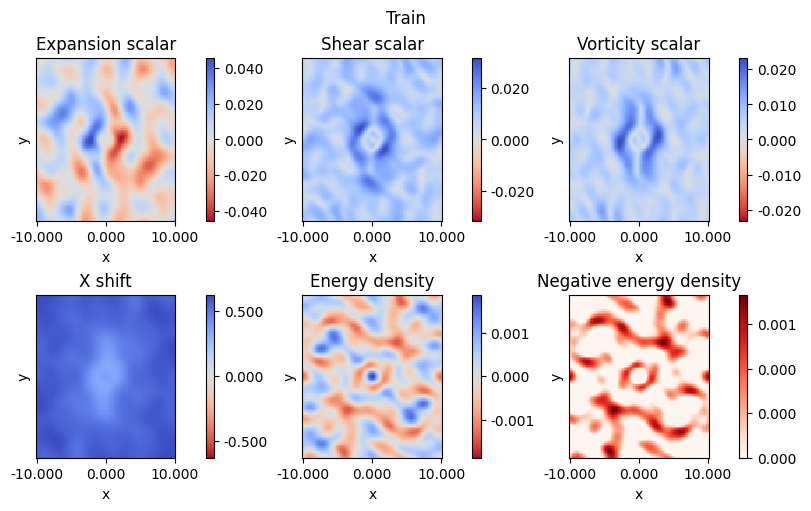

Elapsed: 01:26 | 51 at  1.13s/it, loss=0.009065843

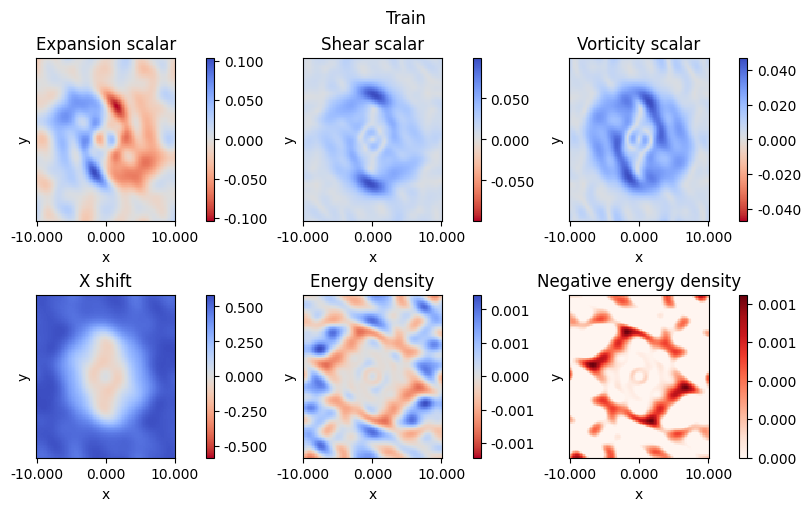

Elapsed: 02:00 | 76 at  1.18s/it, loss=0.005418321

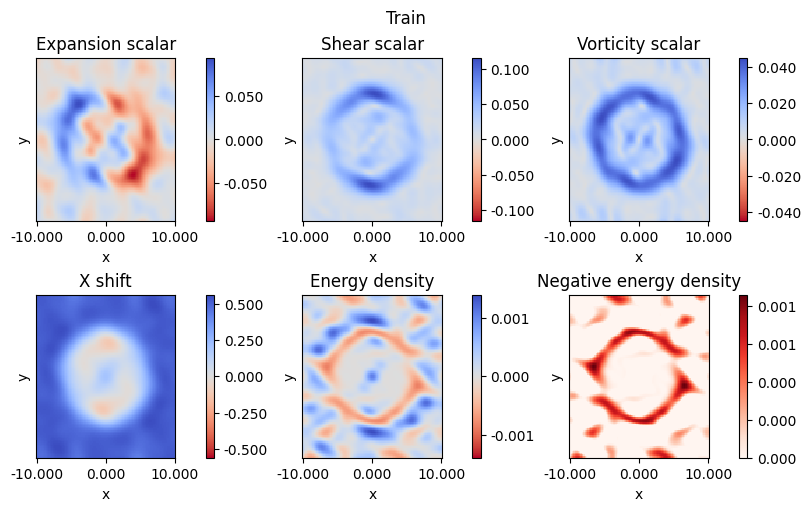

Elapsed: 02:34 | 101 at  1.18s/it, loss=0.004297901 

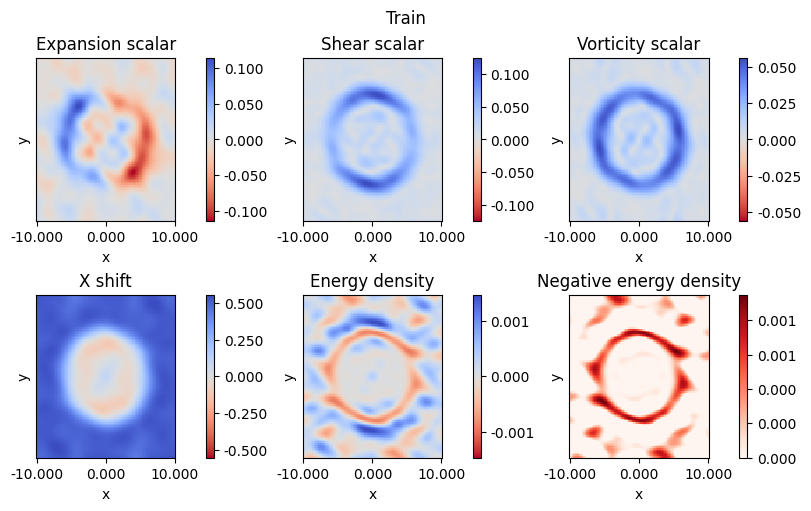

Elapsed: 03:11 | 126 at  1.30s/it, loss=0.0037783515

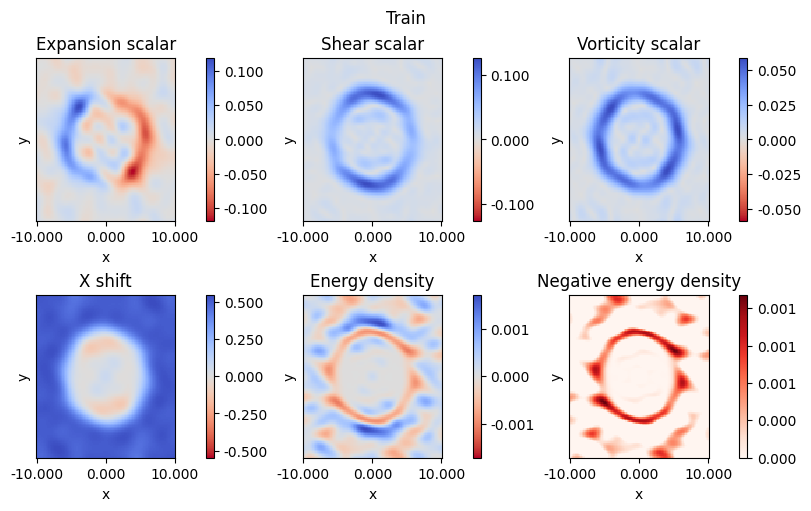

Elapsed: 03:49 | 151 at  1.22s/it, loss=0.003075721 

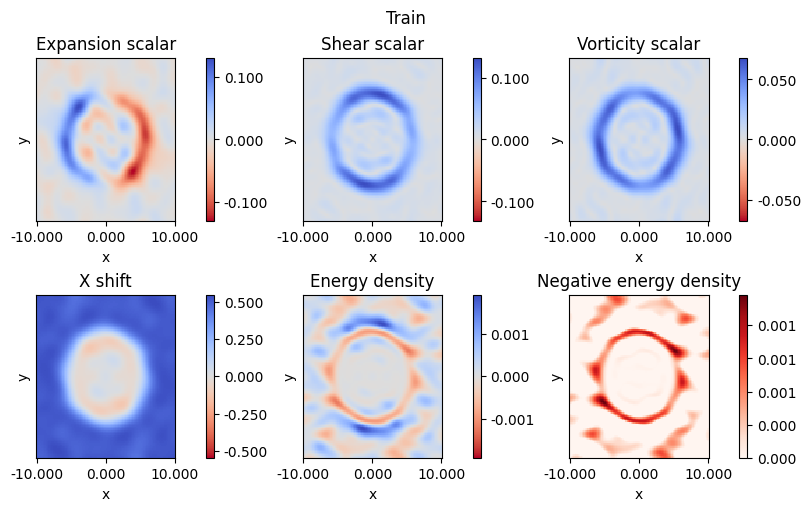

Elapsed: 04:26 | 176 at  1.29s/it, loss=0.0030088997

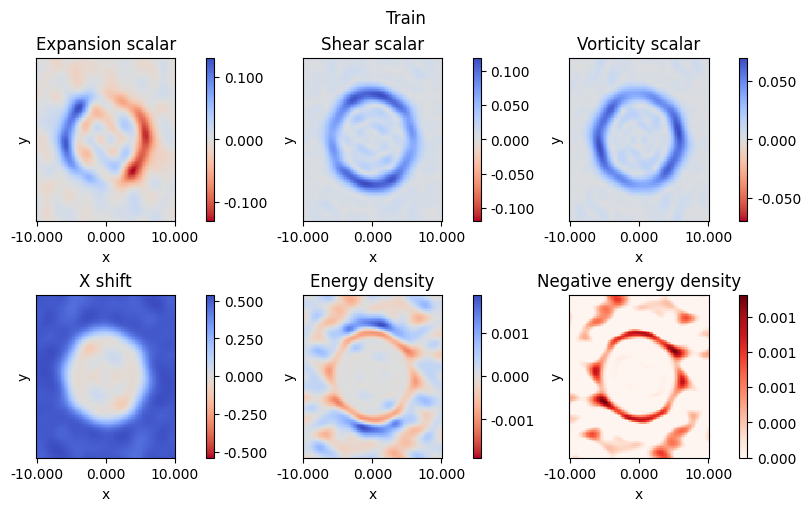

Elapsed: 05:03 | 201 at  1.27s/it, loss=0.0027804042

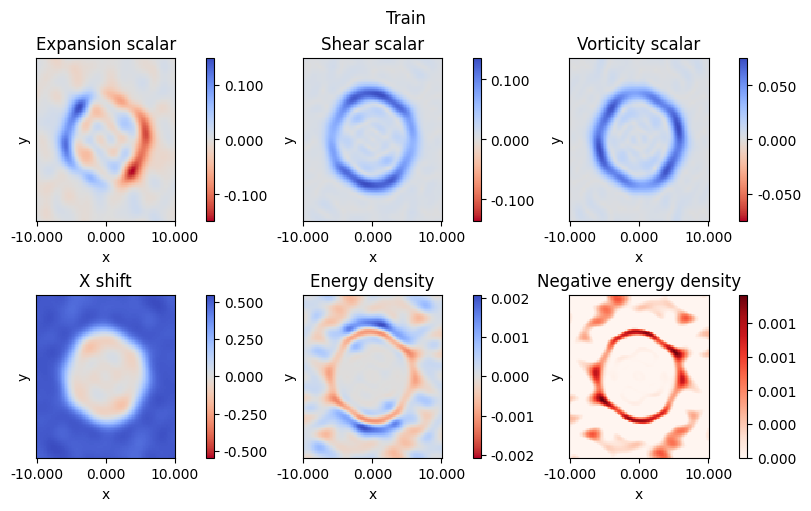

Elapsed: 05:46 | 226 at  1.53s/it, loss=0.002246251 


interrupting training...


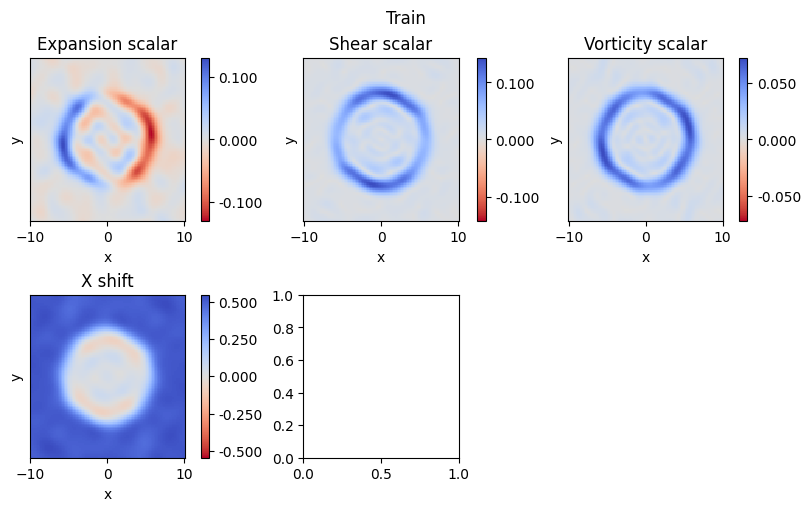

In [8]:
sample_radius = 8
target_velocity = 0.5
negative_energy_penalty = 10.  # minimize negative energy density
energy_density_penalty = 1.  # minimize energy density
energy_compactness_penalty = 1.
energy_bound_radius = 6.
passenger_radius = 2.
T_l2_penalty = 0  # 1.
l2_penalty = 0. # 1e-5

def warp_drive_loss(f_metric, params, coords):
    model = partial(f_metric, params)

    r2 = jnp.sum(coords[1:] ** 2)
    diff_r = r2 - passenger_radius ** 2
    passenger_area_mask = jnp.maximum(0, 1. - jnp.maximum(0, diff_r))

    r2 = jnp.sum(coords[1:] ** 2)
    diff_r = energy_bound_radius ** 2 - r2
    outer_area_mask = jnp.maximum(0, 1. - jnp.maximum(0, diff_r))
    not_outer_area_mask = 1. - outer_area_mask

    # comoving loss
    metric_x = model(coords)
    target_velocity = 0.5
    # Don't think this is quite right for velocity but it does the trick so far
    shift_x = metric_x[0, 1]# / (metric_x[0, 0] ** 2 + 1e-8)
    # no movement in the passenger and warp shell area since we are all comoving
    inner_comoving_loss = not_outer_area_mask * shift_x ** 2
    # rest of the world is moving relative to our frame
    outer_comoving_loss = outer_area_mask * (target_velocity - shift_x) ** 2
    comoving_loss = inner_comoving_loss + outer_comoving_loss

    # flat and empty except in the warp shell
    not_energy_shell_mask = passenger_area_mask + outer_area_mask
    T = stress_energy_tensor(model, coords)
    expansion_loss = expansion_scalar(model, coords) ** 2
    shear_loss = shear_scalar(model, coords) ** 2
    vorticity_loss = vorticity_scalar(model, coords) ** 2
    vacuum_loss = T[0, 0] ** 2
    distortion_loss = not_energy_shell_mask * (vacuum_loss + shear_loss + vorticity_loss + expansion_loss)

    bad_energy_loss = 0.
    if negative_energy_penalty:
        bad_energy_loss += negative_energy_penalty * jnp.maximum(0., -T[0, 0]) ** 2  # penalize negative energy, brother
    if T_l2_penalty:
        bad_energy_loss += T_l2_penalty * (T ** 2).sum()

    return comoving_loss + distortion_loss + bad_energy_loss

# Vectorize the loss function
vectorized_loss_function = jax.jit(jax.vmap(partial(warp_drive_loss, f_metric), in_axes=(None, 0)))

def train(
    loss_function,
    batch_size=1000,
    learning_rate=1e-3,
    num_steps=1_000,
    plot_every=1,
    save_plots=False,
    plots_path='./frames/step_{step}.png',
    display_plots=True,
    sample_radius=8,
    params=None, opt_state=None,
):
    # Define the full loss function over a batch
    @jax.jit
    def wrapped_loss_function(params, batch):
        batch = jnp.array(batch)  # Ensure batch is a proper array
        losses = loss_function(params, batch)
        # good_losses = losses.at[jnp.isnan(losses)].set(0)
        good_losses = losses
        loss = jnp.mean(good_losses)
        # Add L2 regularization term
        if l2_penalty:
            loss = loss + sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)) * l2_penalty
        return loss

    # Initialize the neural network parameters
    rng = jax.random.PRNGKey(42)
    params = params or metric_model_init(rng, jnp.zeros(num_model_inputs))

    # Define the optimizer
    # optimizer = optax.apply_if_finite(optax.adam(learning_rate), 10)
    optimizer = optax.adam(learning_rate)
    if opt_state is None:
        opt_state = optimizer.init(params)

    # Function to update the parameters
    def update(params, opt_state, batch):
        grads = jax.grad(wrapped_loss_function)(params, batch)
        grads = jax.tree.map(lambda g: jnp.clip(g, -1.0, 1.0), grads)  # Gradient clipping
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    rng, batch_rng = jax.random.split(rng)

    try:
        with tqdm(
            bar_format="Elapsed: {elapsed} | {n_fmt} at {rate_fmt}{postfix}",
        ) as t:
            for step in range(num_steps):
                # take random samples of the space
                batch_rng, subkey = jax.random.split(batch_rng)
                # batch = jax.random.uniform(subkey, shape=(batch_size, 4), minval=-sample_radius, maxval=sample_radius)
                batch = jax.random.normal(subkey, shape=(batch_size, 4)) * sample_radius
                params, opt_state = update(params, opt_state, batch)

                if step % 5 == 0:
                    current_loss = wrapped_loss_function(params, batch)
                    if jnp.isnan(current_loss):
                        print("NaN detected in loss, stopping training.")
                        break
                    t.set_postfix(loss=current_loss)
                t.update()
                if step % plot_every == 0:
                    make_plots(partial(f_metric, params), title='Train', w=sample_radius * 1.25, n=100)
                    if save_plots:
                        padded_steps = str(step).zfill(6)
                        plt.savefig(plots_path.format(step=padded_steps))
                    if display_plots:
                        plt.show()
                    plt.close()
    except KeyboardInterrupt:
        print('interrupting training...')
    return params, opt_state

continue_training = False
if not continue_training:
    params = opt_state = None

params, opt_state = train(
    vectorized_loss_function,
    learning_rate=1e-3,
    batch_size=1000,
    plot_every=25,
    save_plots=False,
    plots_path='./frames/step_{step}.png',
    display_plots=True,
    params=params, opt_state=opt_state
)


Let's see how it looks in other levels of zoom.

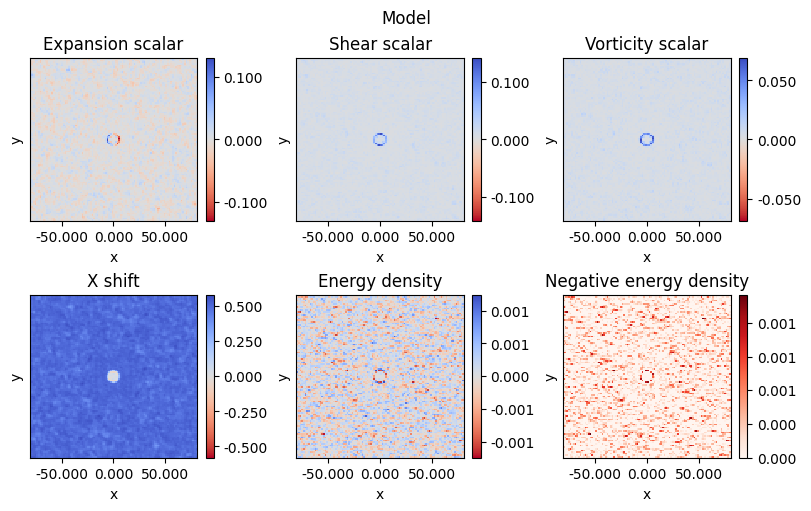

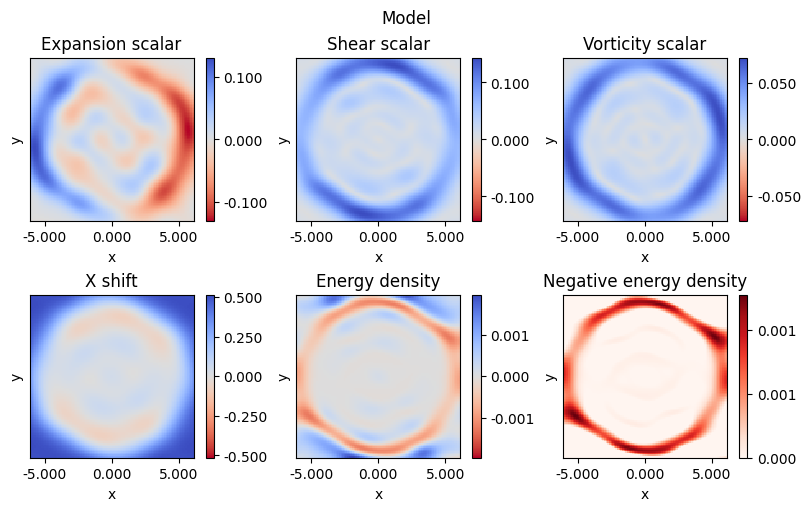

In [9]:
make_plots(partial(f_metric, params), title='Model', w=sample_radius * 10, n=100)
make_plots(partial(f_metric, params), title='Model', w=energy_bound_radius * 1.01, n=100)
